In [4]:
pip install -U --pre astroquery

  Obtaining dependency information for astroquery from https://files.pythonhosted.org/packages/3f/1d/03b4e079882be12ef4a641d30ad50c9044037f5a7a6dc8418352d821b0ff/astroquery-0.4.7.dev9069-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/112.2 kB ? eta -:--:--
     ---------------------------- ---------- 81.9/112.2 kB 2.3 MB/s eta 0:00:01
     -------------------------------------- 112.2/112.2 kB 2.2 MB/s eta 0:00:00
  Obtaining dependency information for pyvo>=1.1 from https://files.pythonhosted.org/packages/f9/88/629d4aebecb9b297cb63c671b0966c19807d383ac88725a2a06b24c39d29/pyvo-1.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/5.2 MB ? eta -:--:--
   --- ------------------------------------ 0.4/5.2 MB 8.5 MB/s eta 0:00:01
   ------ --------------------------------- 0.8/5.2 MB 8.6 MB/s eta 0:00:01
   -------------- ------------------------- 1.9/5.2 MB 13.6 MB/s eta 0:00:01
   ------------------------ --------------- 3.2/5.2 MB 17.3 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.modeling import Fittable1DModel, Parameter
from astroquery.sdss import SDSS

In [9]:
spectrum = SDSS.get_spectra(plate=1349, fiberID=216, mjd=52797)[0]

spectrum[1].columns

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)

In [12]:
flux = spectrum[1].data['flux']
lam = 10**(spectrum[1].data['loglam'])

#Units of the flux
units_flux = spectrum[0].header['bunit']
print(units_flux)

#Units of the wavelength
units_wavelength_full = spectrum[0].header['WAT1_001']
print(units_wavelength_full)

1E-17 erg/cm^2/s/Ang
wtype=linear label=Wavelength units=Angstroms


In [13]:
units_wavelength = units_wavelength_full[36:]
print(units_wavelength)

Angstroms


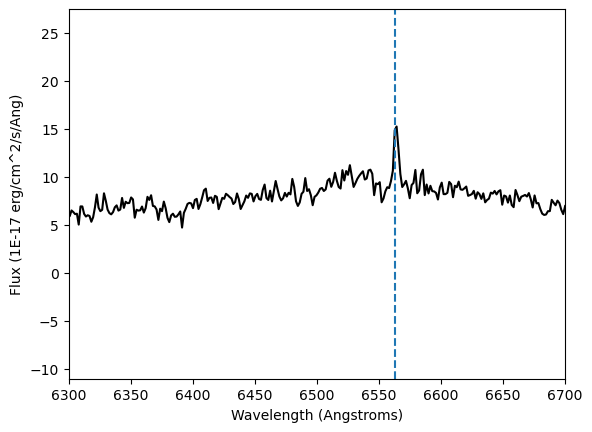

In [14]:
plt.plot(lam, flux, color='k')
plt.xlim(6300,6700)
plt.axvline(x=6563, linestyle='--')
plt.xlabel('Wavelength ({})'.format(units_wavelength))
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

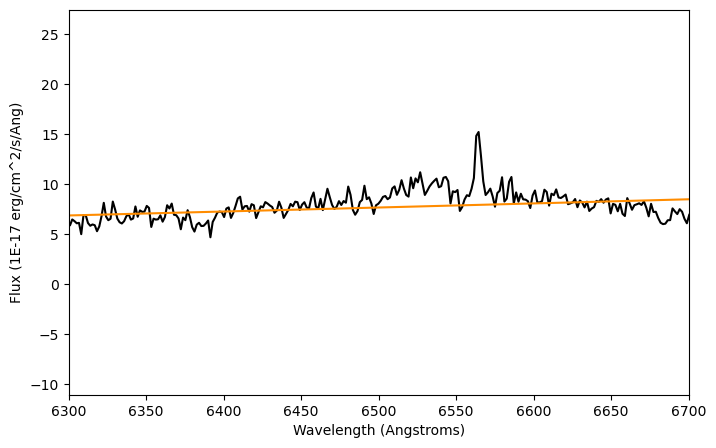

In [15]:
gausian_model = models.Gaussian1D(1, 6563, 10)
fitter = fitting.LevMarLSQFitter()
gaussian_fit = fitter(gausian_model, lam, flux)

plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, gaussian_fit(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [16]:
print(gaussian_fit)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev     
    ----------------- ----------------- -----------------
    16.75070628912542 9456.749530943964 2368.395706441934


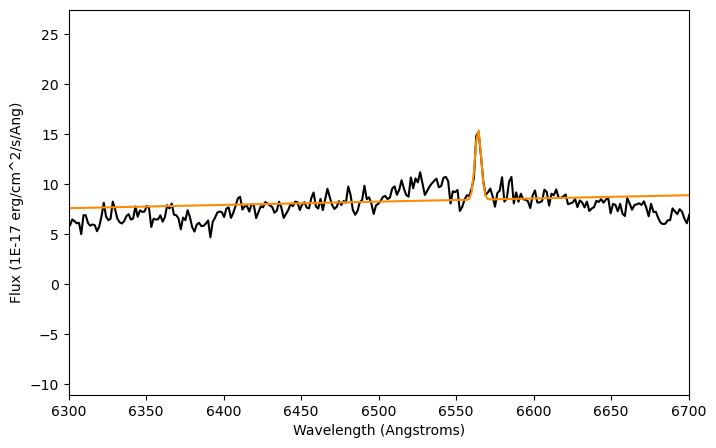

In [19]:
##COMPOUND MODELS

compound_model = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)
fitter = fitting.LevMarLSQFitter()
compound_fit = fitter(compound_model, lam, flux)

plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [20]:
print(compound_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=7.02089174, mean=6564.13631715, stddev=1.97761476)>

    [1]: <Polynomial1D(1, c0=-12.79335619, c1=0.00323995)>
Parameters:
       amplitude_0          mean_0       ...          c1_1        
    ----------------- ------------------ ... ---------------------
    7.020891744278151 6564.1363171493185 ... 0.0032399520530058644


In [21]:
for x,y in zip(compound_fit.param_names, compound_fit.parameters):
    print(x,y)

amplitude_0 7.020891744278151
mean_0 6564.1363171493185
stddev_0 1.9776147551998158
c0_1 -12.79335618554209
c1_1 0.0032399520530058644


In [22]:
compound_fit.amplitude_0

Parameter('amplitude', value=7.020891744278151)

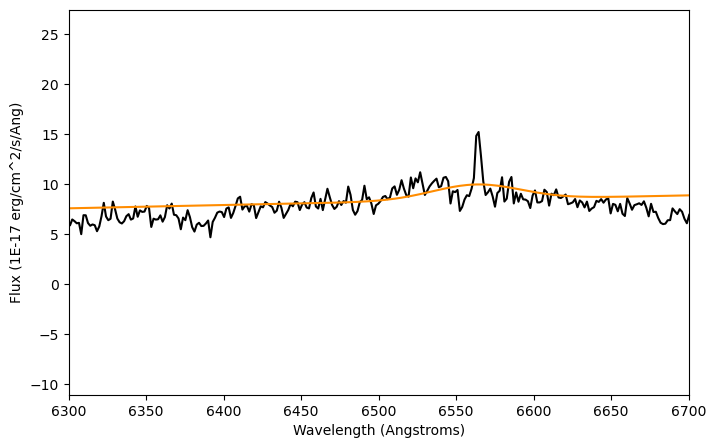

In [23]:
##Fixed and Bounded Models

compound_model_fixed = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)
compound_model_fixed.mean_0.fixed = True

fitter = fitting.LevMarLSQFitter()
compound_fit_fixed = fitter(compound_model_fixed, lam, flux)

plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit_fixed(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()


In [24]:
print(compound_fit_fixed)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=1.53257471, mean=6563., stddev=28.57847528)>

    [1]: <Polynomial1D(1, c0=-12.79103, c1=0.00323745)>
Parameters:
       amplitude_0     mean_0 ...         c0_1                 c1_1        
    ------------------ ------ ... ------------------- ---------------------
    1.5325747104576728 6563.0 ... -12.791030002605527 0.0032374486280527933


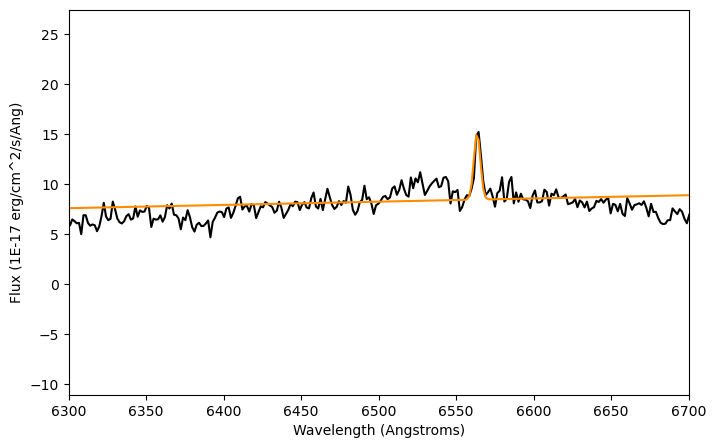

In [25]:
compound_model_bounded = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)
delta = 0.5
compound_model_bounded.mean_0.max = 6563 + delta
compound_model_bounded.mean_0.min = 6563 - delta

fitter = fitting.LevMarLSQFitter()
compound_fit_bounded = fitter(compound_model_bounded, lam, flux)

plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit_bounded(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [26]:
print(compound_fit_bounded)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=6.65730507, mean=6563.5, stddev=2.09182676)>

    [1]: <Polynomial1D(1, c0=-12.79336254, c1=0.00323995)>
Parameters:
       amplitude_0    mean_0 ...         c0_1                 c1_1        
    ----------------- ------ ... ------------------- ---------------------
    6.657305067408649 6563.5 ... -12.793362542046482 0.0032399500252079877


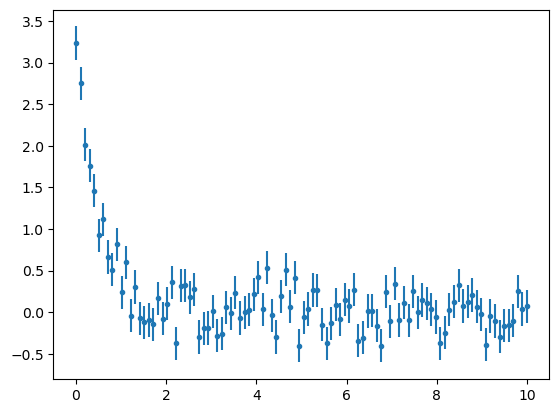

In [27]:
##Custom Model

x1 = np.linspace(0,10,100)

a = 3
b = -2
c = 0
y1 = a*np.exp(b*x1+c)
y1 += np.random.normal(0., 0.2, x1.shape)
y1_err = np.ones(x1.shape)*0.2

plt.errorbar(x1 , y1, yerr=y1_err, fmt='.')
plt.show()

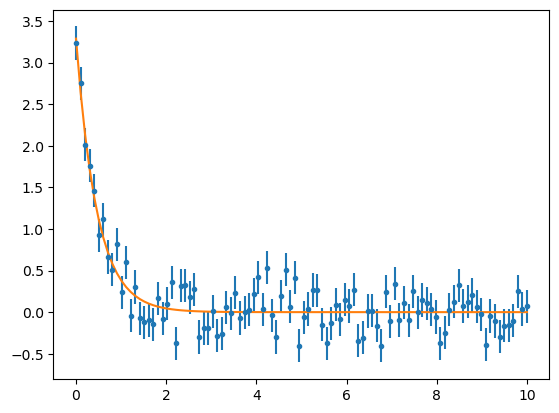

In [30]:
@custom_model
def exponential(x, a=1., b=1., c=1.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(b*x+c)

exp_model = exponential(1.,-1.,1.)  
fitter = fitting.LevMarLSQFitter()
exp_fit = fitter(exp_model, x1, y1, weights = 1.0/y1_err**2)

plt.errorbar(x1 , y1, yerr=y1_err, fmt='.')
plt.plot(x1, exp_fit(x1))
plt.show()

In [31]:
print(exp_fit)

Model: exponential
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                  b                  c         
    ------------------ ------------------ ------------------
    2.0178364590999496 -2.149010828162712 0.4882112903169283


In [32]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

calc_reduced_chi_square(exp_fit(x1), x1, y1, y1_err, len(x1), 3)

1.2366395151363034

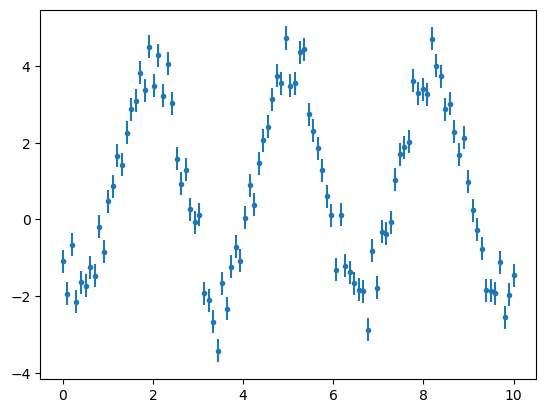

In [33]:
##Full Custom Model

x2 = np.linspace(0,10,100)
a = 3
b = 2
c = 4
d = 1
y2 = a*np.sin(b*x2+c)+d
y2 += np.random.normal(0., 0.5, x2.shape)
y2_err = np.ones(x2.shape)*0.3

plt.errorbar(x2, y2, yerr=y2_err, fmt='.')
plt.show()

In [34]:
class SineNew(Fittable1DModel):
    a = Parameter(default=1.)
    b = Parameter(default=1.)
    c = Parameter(default=1.)
    d = Parameter(default=1.)
        
    @staticmethod
    def evaluate(x, a, b, c, d):
        return a*np.sin(b*x+c)+d
    
    @staticmethod
    def fit_deriv(x, a, b, c, d):
        d_a = np.sin(b*x+c)
        d_b = a*np.cos(b*x+c)*x
        d_c = a*np.cos(b*x+c)
        d_d = np.ones(x.shape)
        return [d_a, d_b, d_c, d_d]

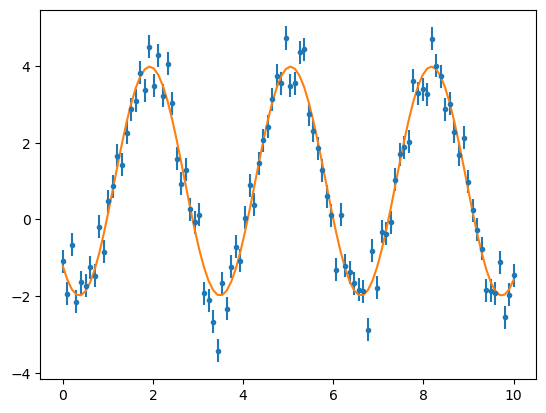

In [36]:
sine_model = SineNew(a=4.,b=2.,c=4.,d=0.)  
fitter = fitting.LevMarLSQFitter()
sine_fit = fitter(sine_model, x2, y2, weights = 1.0/y2_err**2)

plt.errorbar(x2, y2, yerr=y2_err, fmt='.')
plt.plot(x2,sine_fit(x2))
plt.show()

In [38]:
print(sine_fit)

calc_reduced_chi_square(sine_fit(x2), x2, y2, y2_err, len(x2), 3)

Model: SineNew
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                  b                  c                  d         
    ------------------ ------------------ ------------------ ------------------
    2.9840350467262793 2.0118928798477307 3.9755556965407766 1.0006606831072695


2.7289562699231396